# Tech Challenge -> Dados Bolsa de Valores

## <b>Target</b> : Prever se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual

## Mandatório:

- O conjunto de **teste obrigatório** é o último mês (30 dias).
- O modelo precisa atingir **mínimo de 75% de acurácia** nesse período

### Importação de Bibliotecas

# Tech Challenge -> Dados Bolsa de Valores

## <b>Target</b> : Prever se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual

## Mandatório:

- O conjunto de **teste obrigatório** é o último mês (30 dias).
- O modelo precisa atingir **mínimo de 75% de acurácia** nesse período

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.base import clone

import optuna
from optuna.pruners import MedianPruner
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from prophet import Prophet
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
# --- IGNORE ---
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf


### Carregamento e exploração inicial

In [60]:

df = pd.read_csv(r"..\..\Dados Históricos - Ibovespa(3).csv", sep=',')

In [61]:
#Exibe primeiras linhas do dataframe
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
954,03.01.2022,103.922,104.823,106.125,103.413,"11,13M","-0,86%"
955,30.12.2021,104.822,104.106,105.269,104.106,"11,14M","0,69%"
956,29.12.2021,104.107,104.863,105.190,103.851,"6,59M","-0,72%"
957,28.12.2021,104.864,105.555,105.652,104.503,"7,51M","-0,65%"
958,27.12.2021,105.554,104.892,105.694,104.798,"7,59M","0,63%"


In [62]:
#Exibe informações gerais sobre o DataFrame
print('-'*64)
print('Quantidade de colunas e linhas',df.shape)
print('-'*64)

print('Quantidade total de nulos:',df.isnull().sum().sum())
print('-'*64)

print('Informações do DataFrame:\n')

print(df.info())
print('-'*64)


print('Estatísticas descritivas do DataFrame:\n')

df.describe().T

----------------------------------------------------------------
Quantidade de colunas e linhas (959, 7)
----------------------------------------------------------------
Quantidade total de nulos: 0
----------------------------------------------------------------
Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      959 non-null    object 
 1   Último    959 non-null    float64
 2   Abertura  959 non-null    float64
 3   Máxima    959 non-null    float64
 4   Mínima    959 non-null    float64
 5   Vol.      959 non-null    object 
 6   Var%      959 non-null    object 
dtypes: float64(4), object(3)
memory usage: 52.6+ KB
None
----------------------------------------------------------------
Estatísticas descritivas do DataFrame:



,count,mean,std,min,25%,50%,75%,max
Último,959.0,120.914576,11.700480,96.121,111.5440,120.586,129.6010,146.492
Abertura,959.0,120.871945,11.683371,96.119,111.4645,120.561,129.5280,146.492
Máxima,959.0,121.767710,11.614397,96.971,112.5285,121.607,130.1425,147.578
Mínima,959.0,120.038944,11.796513,95.267,110.3985,120.022,128.7335,146.067


### Limpeza dos dados

In [63]:
#Transforma a coluna 'Data' em formato datetime
df['Data']=pd.to_datetime(df['Data'],format='%d.%m.%Y')

In [64]:
# conversão de string pt-br com % para float

def converter_percentual(x):

    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace('%','').replace('.','').replace(',','.')
    try:
        return float(s)/100.0
    except:
        return np.nan
    
def converter_valor_volume(x):
    try:
        s = str(x).strip().upper().replace(',', '.')
        if s.endswith('M'):
            return float(s[:-1]) * 1_000_000
        elif s.endswith('B'):
            return float(s[:-1]) * 1_000_000_000
        else:
            return float(s)
    except:
        return None


In [65]:
#aplica as correções para volume e variações percentuais
df['Vol.'] = df['Vol.'].apply(converter_valor_volume)
df['Var%'] = df['Var%'].apply(converter_percentual)

In [66]:
#Variaveis de data
df['ano']=df['Data'].dt.year
df['mes']=df['Data'].dt.month
df['day_of_week']=df['Data'].dt.day_of_week
df['Anomes']=df['Data'].dt.strftime('%m.%y')

### Análise Exploratória

In [67]:
print('Novas Estatísticas descritivas do DataFrame:\n')

df.describe().T

Novas Estatísticas descritivas do DataFrame:



,count,mean,min,25%,50%,75%,max,std
Data,959,2023-11-26 14:57:56.120959232,2021-12-27 00:00:00,2022-12-10 12:00:00,2023-11-27 00:00:00,2024-11-06 12:00:00,2025-10-24 00:00:00,NaN
Último,959.0,120.914576,96.121,111.544,120.586,129.601,146.492,11.70048
Abertura,959.0,120.871945,96.119,111.4645,120.561,129.528,146.492,11.683371
Máxima,959.0,121.76771,96.971,112.5285,121.607,130.1425,147.578,11.614397
Mínima,959.0,120.038944,95.267,110.3985,120.022,128.7335,146.067,11.796513
Vol.,959.0,1981453514.077164,4330000.0,9945000.0,12310000.0,17455000.0,24870000000.0,3981848092.265336
Var%,959.0,0.000402,-0.0335,-0.0058,0.0003,0.0069,0.0554,0.010604
ano,959.0,2023.422315,2021.0,2022.0,2023.0,2024.0,2025.0,1.105104
mes,959.0,6.296142,1.0,3.0,6.0,9.0,12.0,3.345126
day_of_week,959.0,1.995829,0.0,1.0,2.0,3.0,4.0,1.414207


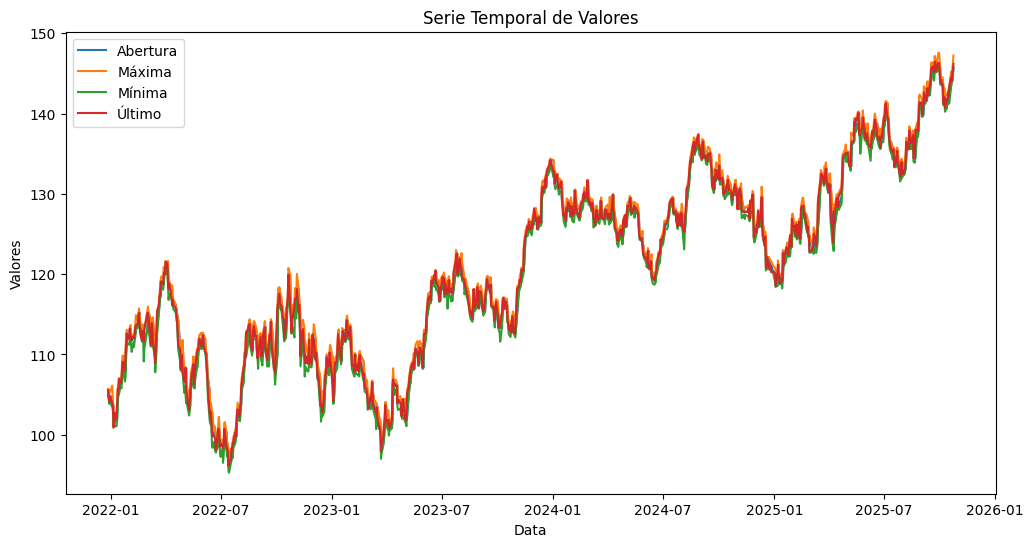

In [68]:
#Plotando série temporal dos valores de Abertura, Máxima, Mínima e Último

plt.figure(figsize=(12,6))
for col in ['Abertura','Máxima','Mínima','Último']:
  sns.lineplot(data=df,x='Data',y=col,label=col)
plt.title("Serie Temporal de Valores")
plt.xlabel("Data")
plt.ylabel("Valores")
plt.legend()
plt.show()

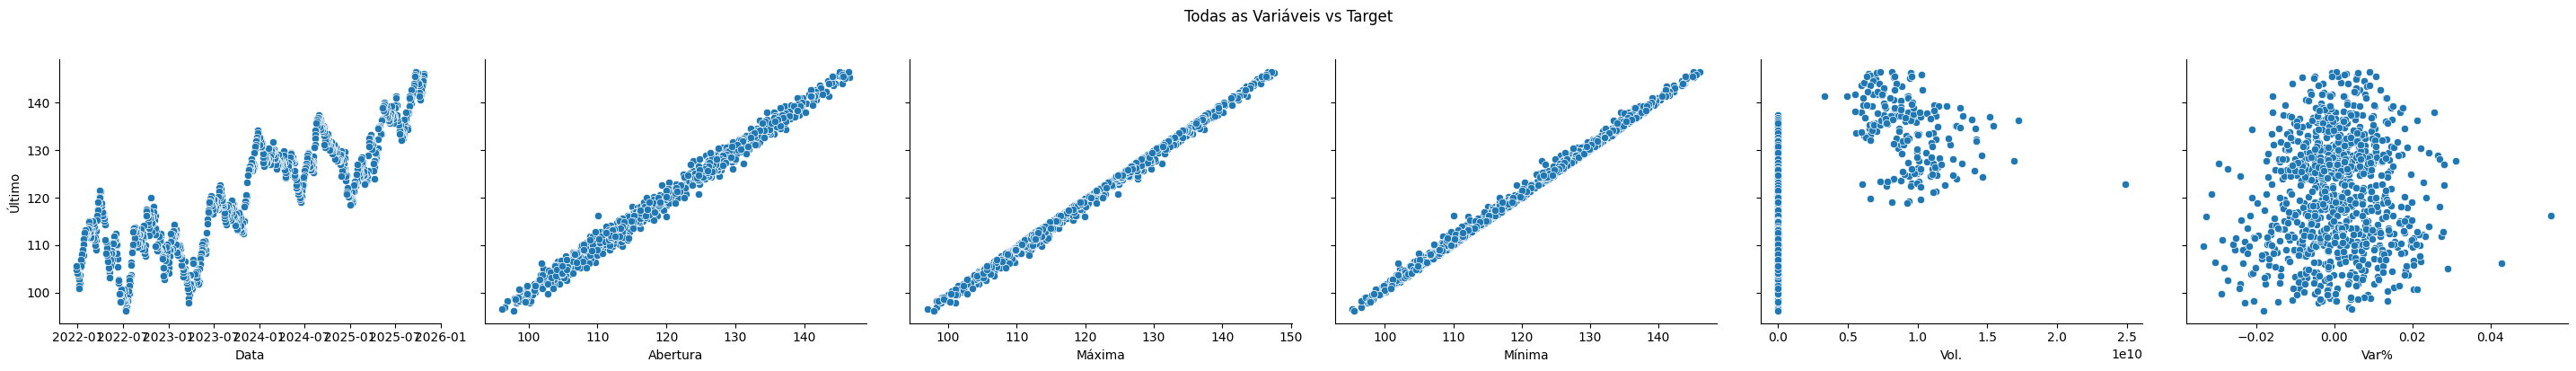

In [69]:
# Pairplot destacando a variável target
sns.pairplot(df, 
             x_vars=['Data',  'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'],
             y_vars=['Último'],
             height=4,
             aspect=1.2)
plt.suptitle('Todas as Variáveis vs Target', y=1.02)
plt.tight_layout()
plt.show()

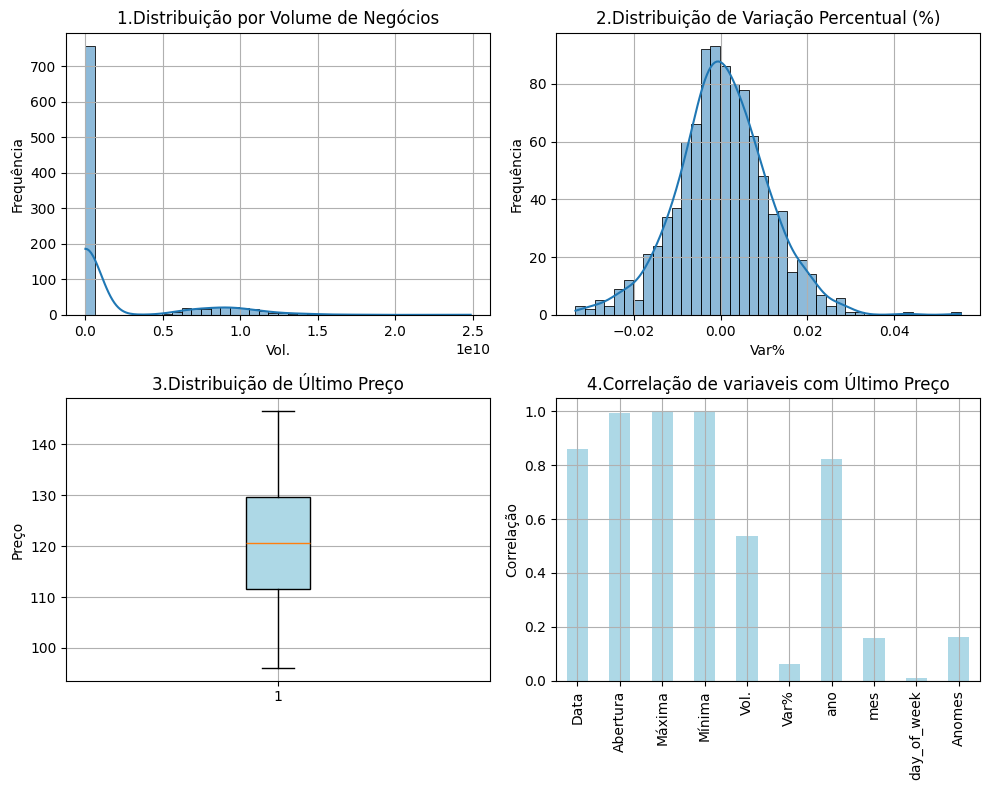

In [70]:
# Configuração dos subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Histograma de Volume de Negócios
sns.histplot(df['Vol.'],bins=40, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('1.Distribuição por Volume de Negócios')
axs[0, 0].set_ylabel('Frequência')
axs[0, 0].grid(True)

# Histograma de Variação Percentual
sns.histplot(df['Var%'],bins=40, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('2.Distribuição de Variação Percentual (%)')
axs[0, 1].set_ylabel('Frequência')
axs[0, 1].grid(True)

# Boxplot para entender comportamento de Último Preço
axs[1, 0].boxplot(df['Último'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1, 0].set_title('3.Distribuição de Último Preço')
axs[1, 0].set_ylabel('Preço')

axs[1, 0].grid(True)

# Correlação de variaveis com Último Preço
df.corr()['Último'].drop('Último').plot(kind='bar', ax=axs[1, 1], color='lightblue')   

axs[1, 1].set_title('4.Correlação de variaveis com Último Preço')
axs[1, 1].set_ylabel('Correlação')
axs[1, 1].grid(True)


plt.tight_layout()
plt.show()

### Funções de criação de features e metricas


In [71]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    """Função para calcular métricas de avaliação: MAE, MSE e MAPE.
    Parametros:
    y_true: Valores reais
    y_pred: Valores previstos
    Retorna:
    Tuple contendo MAE, MSE e MAPE"""

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape

#função de exibição dos métricos
def print_metrics(metrics):
    """Função para imprimir as métricas de avaliação.
    Parametros:
    metrics: Tuple contendo MAE, MSE e MAPE
    """
    
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

In [72]:

#Função para criação de features
def create_features(df,date_col,close_col,vol_col,windows=(5,10,20,50,100)):
    """Cria features técnicas para análise de séries temporais financeiras.
    Parâmetros:
    df: DataFrame contendo os dados financeiros.
    date_col: Nome da coluna de datas.
    close_col: Nome da coluna de preços de fechamento.
    vol_col: Nome da coluna de volume.
    windows: Tupla de janelas para cálculo de médias móveis e outros indicadores.
    Retorna:
    DataFrame com as novas features criadas."""


    df = df.copy()

    # Ordenando os dados pela data
    df = df.sort_values(date_col).reset_index(drop=True)

    # Calculos simples de retornos para o periodo de 1, 5 e 10 dias
    df['ret_1'] = df[close_col].pct_change(1) # retorno diário

    df["ret_5d"]  = df[close_col].pct_change(5)
    df["ret_10d"] = df[close_col].pct_change(10)


    # médias e EMAs multijanelas
    for w in windows:
        df[f'mm_{w}']  = df[close_col].rolling(window=w, min_periods=w).mean()
        df[f'ema_{w}'] = df[close_col].ewm(span=w, adjust=False).mean()
        # spread preço - média
        df[f'spread_mm{w}'] = df[close_col] - df[f'mm_{w}']
        # MÉDIA de volume
        
        df[f'volm_{w}'] = df[vol_col].rolling(window=w, min_periods=w).mean()

    # relações preço vs média (com eps para evitar div/0)
    eps = 1e-9
    for w in windows:
        df[f'close_over_mm{w}'] = (df[close_col] / (df[f'mm_{w}'] + eps)) - 1

    # Bandas de Bollinger (20 dias, 2 desvios)
    w=20
    std = df[close_col].rolling(w).std()
    ma=df['mm_20']
    df["bb_width"] = ((ma + 2*std) - (ma - 2*std)) / ma

    #Função para cálculo do RSI
    def compute_rsi(series, window=14):
        delta = series.diff()
        up = np.where(delta > 0, delta, 0.0)
        down = np.where(delta < 0, -delta, 0.0)
        roll_up = pd.Series(up, index=series.index).rolling(window).mean()
        roll_down = pd.Series(down, index=series.index).rolling(window).mean()
        rs = roll_up / roll_down.replace(0, np.nan)
        return 100.0 - (100.0 / (1.0 + rs))

    df["rsi_14"] = compute_rsi(df[close_col], 14)
    df['Target'] = df[close_col].shift(-1)
    
    print("Quantidade de valores nulos após criação de features:")
    print(df.isna().sum().sum())
    df = df.dropna().reset_index(drop=True)
    print('-'*64)
    print("Quantidade de linhas após remoção dos nulos:")
    print(len(df))
    print('-'*64)

    return df

In [73]:
df=create_features(df,'Data','Último','Vol.',windows=(5,10,20,50,75,100,150,200))

Quantidade de valores nulos após criação de features:
2457
----------------------------------------------------------------
Quantidade de linhas após remoção dos nulos:
759
----------------------------------------------------------------


In [74]:


def select_features(train,test,target1=['Target','Último'],target='Target',k=10):
    """Seleciona as melhores features com base em um modelo de regressão.
    Parâmetros:
    train: DataFrame de treinamento.
    test: DataFrame de teste.
    target1: Lista de colunas alvo.
    target: Nome da coluna alvo principal.
    k: Número de features a serem selecionadas.
    Retorna:
    Lista de features selecionadas.  
    """
  


    
    #Seleção das colunas de features, excluindo colunas alvo e de data
    feature_cols=[col for col in train.columns if col not in target1 and col != 'Data' ]
    train = train[feature_cols + target1].dropna()
    test = test[feature_cols].dropna()
    X_train = train[feature_cols]
    y_train = train[target]
    
    


    def build_regression_selector(feature_cols, k=k):
        """Função para construir um pipeline de seleção de features e modelo de regressão.
        Parâmetros:
        feature_cols: Lista de colunas de features.
        k: Número de features a serem selecionadas.
        Retorna:
        Pipeline com seleção de features e modelo de regressão."""

        return Pipeline(steps=[
        ("scaler", StandardScaler()),
        #Algoritmo de seleção de features, usamos o KBest com f_regression pois é adequado para regressão onde a variável alvo é contínua e possui forte correlação linear com as features
        ("selector", SelectKBest(score_func=f_regression, k=k)),
        #Definição do modelo de regressão, usamos ridge pois é robusto e lida bem com a correlação entre features
        ("model", Ridge())
    ])

    # Configuração do TimeSeriesSplit para validação cruzada em séries temporais, definimos 5 splits pois é um valor comum que equilibra bem entre viés e variância
    tscv = TimeSeriesSplit(n_splits=5)
    # Construção do pipeline
    pipe = build_regression_selector(feature_cols, k=k)

    # Definição da grade de hiperparâmetros para busca em grid, otimizando o número de features e o parâmetro alpha do ridge
    # Aqui ajustamos os parametros para explorar melhor o modelo e os valores são selecionados com base em experimentação prévia
    param_grid = {
        "selector__k": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "model__alpha": [0.1, 1.0, 5.0, 10.0]
}
    
    # Aqui chamamos o GridSearchCV para encontrar a melhor combinação de hiperparâmetros com base na métrica de erro absoluto médio negativo
    g = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")
    g.fit(X_train, y_train)


    # Extração das features selecionadas
    mask = g.best_estimator_.named_steps["selector"].get_support()
    #Passando para lista os nomes das features selecionadas
    selected_features = list(X_train.columns[mask])

   
    print("Selected Features:", selected_features)
    
    return selected_features

### Auto Regressão


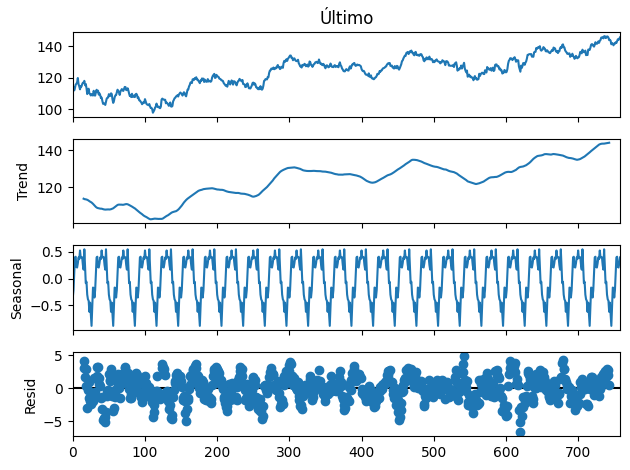

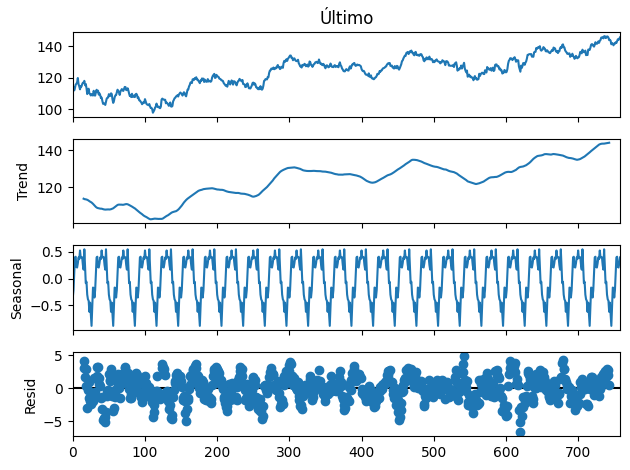

In [75]:
# Análise de decomposição sazonal
result= seasonal_decompose(df['Último'], model='additive', period=30)
result.plot()

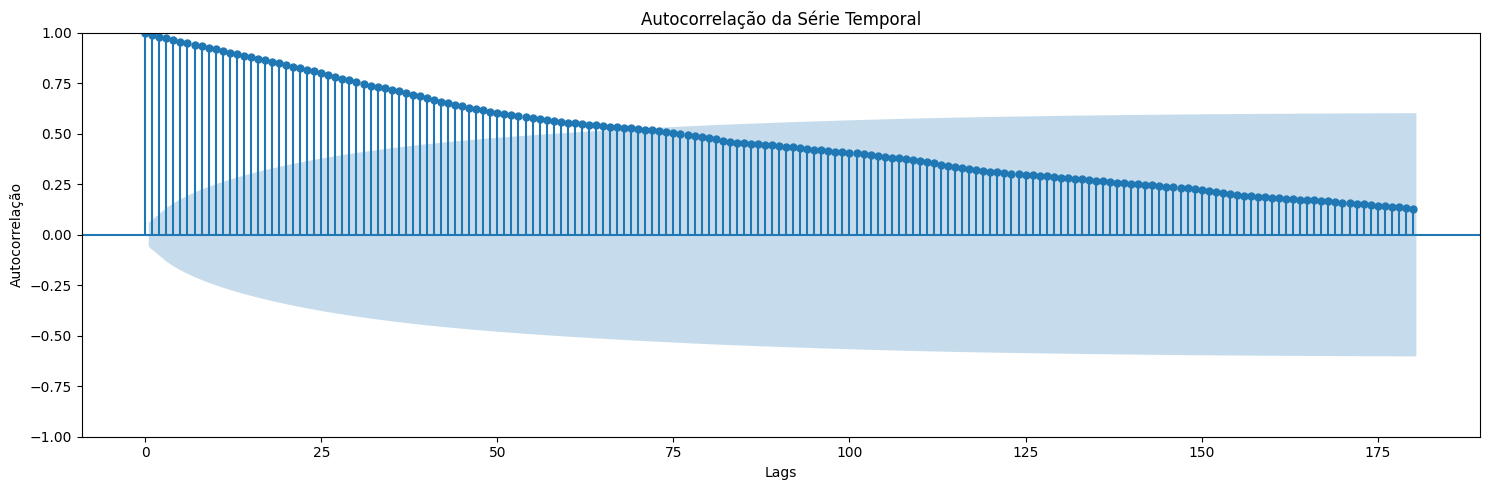

Coeficiente de interceptação da ACF no lag 70


In [76]:
# Função para plotar ACF
def plot_acf(data, lags=365, title="Autocorrelação da Série Temporal"):
    """Plota a função de autocorrelação (ACF) de uma série temporal.
        Parâmetros:
        data: Série temporal (array-like).
        lags: Número de lags a serem exibidos.
        title: Título do gráfico.
        """

    fig, ax = plt.subplots(figsize=(15, 5))
    #Chamando a função de plotagem da ACF do statsmodels
    _plot_acf(data, lags=lags, ax=ax, alpha=0.1)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)
    plt.show()

    #Função para identificar o ponto de interceptação dos coeficientes ACF com o intervalo de confiança
    acf_x = sm.tsa.acf(data, alpha=0.1, nlags=365)
    acf, ci = acf_x[:2]
    # Identificando o ponto de interceptação
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Coeficiente de interceptação da ACF no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da ACF não interceptam o limite")

plot_acf(df["Último"], lags=180)


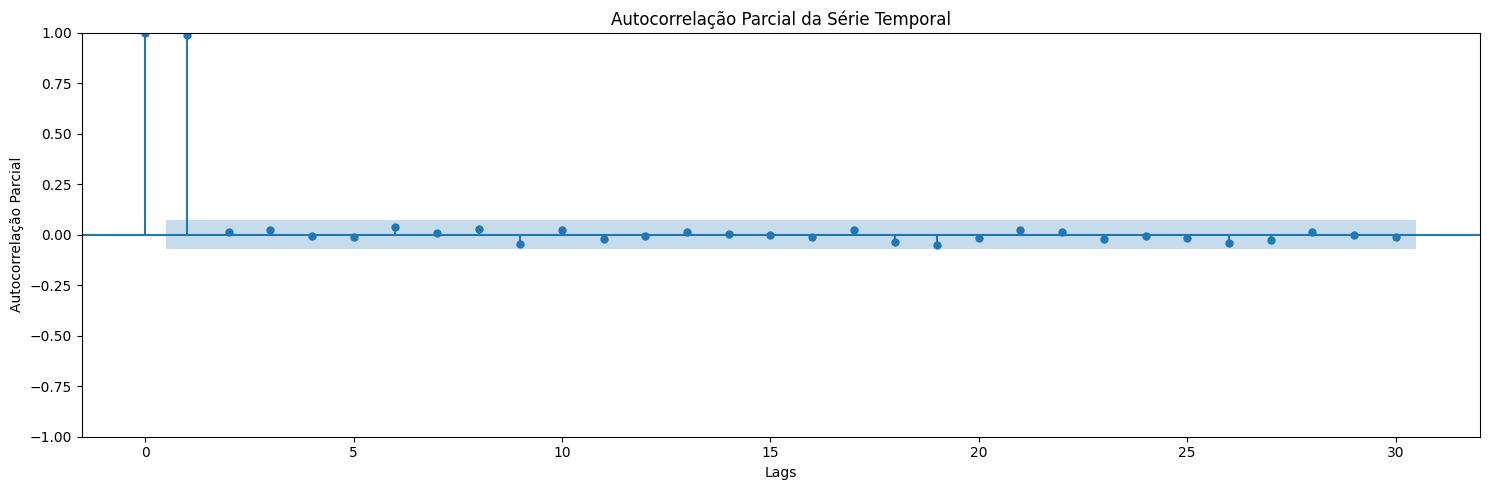

Coeficiente de interceptação da PACF no lag 2


In [77]:
# Função para plotar PACF
def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):
    """Plota a função de autocorrelação parcial (PACF) de uma série temporal.
        Parâmetros:
        data: Série temporal (array-like).
        lags: Número de lags a serem exibidos.
        title: Título do gráfico.
        """

    fig, ax = plt.subplots(figsize=(15, 5))
    #Chamando a função de plotagem da PACF do statsmodels
    _plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)
    plt.show()
    pacf_x = sm.tsa.pacf(data, alpha=0.05, nlags=lags)
    pacf, ci = pacf_x[:2]
    intercept_point = np.where(abs(pacf) < (ci[:, 1] - pacf))
    if intercept_point[0].size > 0:
        print(
            f"Coeficiente de interceptação da PACF no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da PACF não interceptam o limite")
    
plot_pacf(df["Último"])

In [78]:
# Teste de Dickey-Fuller aumentado (ADF)
# Aqui verificamos a estacionariedade da série temporal usando o teste ADF
adf_result = sm.tsa.adfuller(df["Último"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# Interpretamos uma serie menor que 0.05 como estacionária
if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -1.0021031938977978
p-value: 0.7524964368015556
Critical Values: {'1%': -3.439006442437876, '5%': -2.865360521688131, '10%': -2.5688044403756587}
A série temporal não é estacionária


In [79]:

# Teste de Dickey-Fuller aumentado (ADF)
# Aplicando a diferenciação
adf_result = sm.tsa.adfuller(df["Último"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -27.881563385332615
p-value: 0.0
Critical Values: {'1%': -3.4390179167598367, '5%': -2.8653655786032237, '10%': -2.5688071343462777}
A série temporal é estacionária


In [80]:
# Determinação dos parâmetros p, d, q para o modelo ARIMA
#função sm.tsa.acf de autocorrelação para trazer o valor do lag onde a ACF cruza o intervalo de confiança representado por q
acf_x = sm.tsa.acf(df["Último"], alpha=0.1, nlags=365)
#o retorno da função é uma tupla onde o primeiro elemento são os valores da acf e o segundo são os intervalos de confiança
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 90% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df["Último"], alpha=0.1, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 90% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

In [81]:
# parâmetros do modelo ARIMA
p, q, d

(2, 70, 1)

In [82]:
# Aqui usamos a função pm auto_arima para determinar os melhores parâmetros sazonais do modelo ARIMA
# passamos m=5 pois as negociações na bolsa ocorrem em dias úteis, resultando em um padrão semanal de 5 dias
# Também usamos stepwise=True para acelerar o processo de busca dos melhores parâmetros
# Usamos a série original sem diferenciação, pois o auto_arima já lida com isso internamente 
model = pm.auto_arima(
    df["Último"],
    seasonal=True,
    m=5,
    stepwise=True,
)

# Resumo do modelo ARIMA ajustado
print(model.summary())

# Detected seasonal order
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  759
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1213.291
Date:                Mon, 27 Oct 2025   AIC                           2436.581
Time:                        21:47:15   BIC                           2459.735
Sample:                             0   HQIC                          2445.498
                                - 759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3442      0.018    -18.814      0.000      -0.380      -0.308
ar.L2         -0.9764      0.017    -57.858      0.000      -1.009      -0.943
ma.L1          0.3517      0.028     12.788      0.0

### Separação de dataset entre treino e teste

In [83]:
#Aqui realizamos a separação do dataset de acordo com parametros do tech challenge
train_size = df.shape[0] - 30
train,test= df[:train_size], df[-30:]

In [84]:
train.isna().sum().sum()

0

In [85]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [86]:
train.shape, test.shape

((729, 57), (30, 57))

In [87]:
selected_features=select_features(train,test)

Selected Features: ['Abertura', 'Máxima', 'Mínima', 'mm_5', 'ema_5', 'mm_10', 'ema_10', 'mm_20', 'ema_20']


In [88]:
exog_train = train[selected_features]
exog_test= test[selected_features]



In [89]:
# Modelo Sarimax
# Aqui usamos a classe SARIMAX da biblioteca statsmodels para ajustar o modelo SARIMAX com os parâmetros p, d, q e a ordem sazonal determinada anteriormente
# Passamos todos os dados de treino com as variaveis selecionadas como exógenas
model = sm.tsa.statespace.SARIMAX(
    
    train["Último"],
    exog=exog_train,
    order=(
        p,
        d,
        q,
    ), 
    seasonal_order=seasonal_order,
)
# passando os dados para ajustar o modelo
results = model.fit()

# previsão dos dados de teste
# usamos a função get_forecast para obter as previsões para o período de teste, passando as variáveis exógenas correspondentes
# o uso do predicted_mean nos dá os valores previstos diretamente

sarimax = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean



In [90]:
metrics_sarimax = calculate_metrics(test["Último"], sarimax)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 0.739099941500741
MSE: 0.8189094658104054
MAPE: 0.51 %


###  Modelo PROPHET

In [91]:
#Modelo Prophet
train_prophet = train.rename(columns={"Data": "ds", "Último": "y"})
test_prophet = test.rename(columns={"Data": "ds", "Último": "y"})

In [92]:
model = Prophet( daily_seasonality=True,weekly_seasonality=True, yearly_seasonality=True)
for c in selected_features:
    model.add_regressor(c)

model.fit(train_prophet)


future = model.make_future_dataframe(periods=len(test))
future[selected_features] = pd.concat([train_prophet[selected_features], test_prophet[selected_features]], ignore_index=True)
forecast = model.predict(future)
preds_prophet = forecast['yhat'].iloc[-len(test):].values

21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
metrics_prophet = calculate_metrics(test["Último"], preds_prophet)
print("Prophet Metrics:")
print_metrics(metrics_prophet)

Prophet Metrics:
MAE: 0.44661990494293113
MSE: 0.48100388416152257
MAPE: 0.31 %


Prophet Metrics:
MAE: 0.46703135933259643
MSE: 0.5072215725933846
MAPE: 0.33 %

### Verificando Resultados

In [94]:



# Hiperparâmetro tuning para o modelo Prophet
# o padrão do prophet é 0.05 para changepoint_prior_scale e 10.0 para seasonality_prior_scale
# portanto aqui testamos valores mais baixos para changepoint_prior_scale e valores mais altos para seasonality_prior_scale
# pois entendemos que o ibovespa tende a seguir tendencias mais suaves e tem forte sazonalidade anual e diária

param_grid = {
    'changepoint_prior_scale': [0.01, 0.5, 0.1, 0.3],#Controla a flexibilidade das mudanças de tendência no modelo
    'seasonality_prior_scale': [1.0, 2.0, 3.0, 5.0],#Controla a força da sazonalidade no modelo
    'seasonality_mode': ['additive', 'multiplicative'], # Define o modo de sazonalidade 
    # Método Additive assume que a sazonalidade é constante ao longo do tempo, enquanto o Multiplicative assume que a sazonalidade varia proporcionalmente ao nível da série temporal
    'changepoint_range': [0.8, 0.7, 0.9, 1] #Define a proporção do histórico de dados em que os pontos de mudança podem ocorrer, o padrão é 0.8
}

all_params = [
    dict(zip(param_grid.keys(), v)) # Cria um dicionário de parâmetros para cada combinação
    for v in itertools.product(*param_grid.values()) # Gera todas as combinações possíveis dos valores dos hiperparâmetros
]


metrics = []
# Loop sobre todas as combinações de hiperparâmetros
for params in all_params:
    # para cada combinação, criamos e ajustamos um modelo Prophet com os parâmetros atuais

    m = Prophet(**params, daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=False)
    # adicionando as variaveis exógenas
    for c in selected_features:
        m.add_regressor(c)

    m.fit(train_prophet)
    # Realizamos a validação cruzada temporal usando a função cross_validation do Prophet
    # Passamos o modelo ajustado, o periodo inicial de treinamento, o período entre as previsões e o horizonte de previsão
    # O período inicial de 540 dias corresponde de acordo com a quantidade de dados disponíveis
    # o período de 180 dias corresponde a um semestre de negociações
    # o horizonte de 180 dias corresponde a previsão para o próximo semestre
    
    df_cv = cross_validation(m, initial='540 days', period='180 days', horizon='180 days')
    # Calculamos as métricas de desempenho usando a função performance_metrics do Prophet
    df_p = performance_metrics(df_cv, rolling_window=0.1)
    metrics.append((params, df_p['rmse'].values[0]))
print("Hyperparameter tuning completed.")
print(metrics)
best_params, best_rmse = min(metrics, key=lambda x: x[1])
print("Best Parameters:", best_params)
print("Best MSE:", best_rmse)


21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.76it/s]21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.75it/s]21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:00 

Hyperparameter tuning completed.
[({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}, 0.1429240506589082), ({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}, 0.1528301541566525), ({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}, 0.14641955818396313), ({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 1}, 0.14168343892122723), ({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}, 0.14501540519615522), ({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}, 0.1402605273757939), ({'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'sea

In [95]:
m = Prophet(**best_params, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
for c in selected_features:
    m.add_regressor(c)

m.fit(train_prophet)


future = m.make_future_dataframe(periods=len(test))
future[selected_features] = pd.concat([train_prophet[selected_features], test_prophet[selected_features]], ignore_index=True)
forecast = m.predict(future)
preds_prophet_hype = forecast['yhat'].iloc[-len(test):].values

21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:49 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
metrics_prophet = calculate_metrics(test["Último"], preds_prophet_hype)
print("Prophet Metrics:")
print_metrics(metrics_prophet)

Prophet Metrics:
MAE: 0.43840158265241297
MSE: 0.45826273098011794
MAPE: 0.30 %


In [97]:
test['prophet']=np.array(preds_prophet)
test['sarimax']=np.array(sarimax)
test['prophet2']=np.array(preds_prophet_hype)


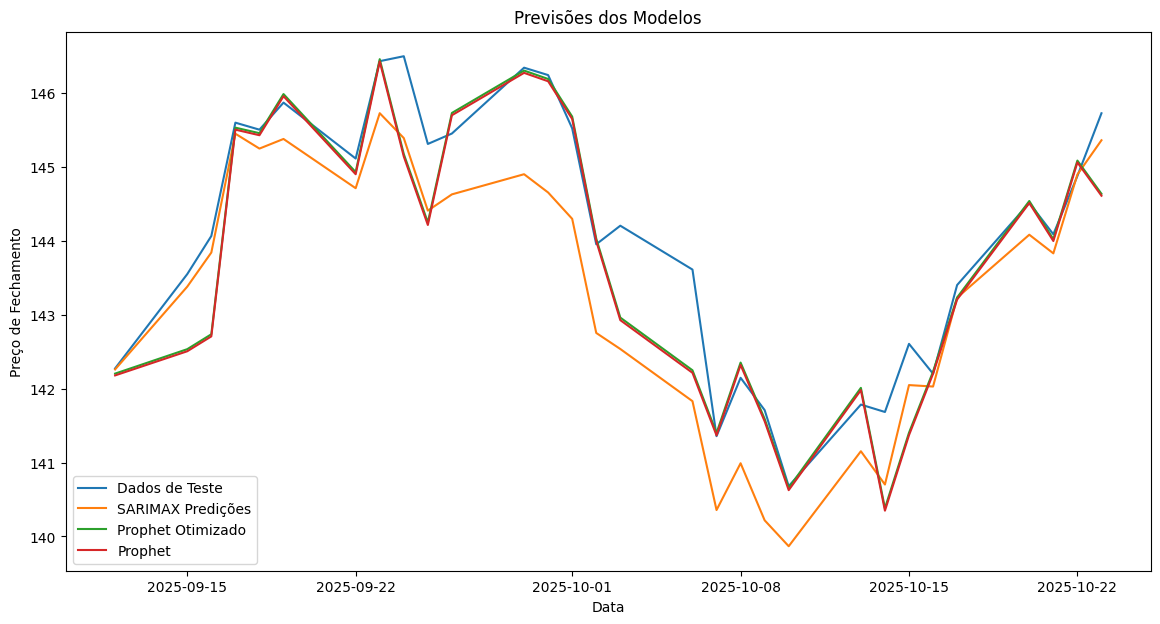

In [98]:
# plotando as predições 
plt.figure(figsize=(14, 7))
plt.plot(test["Data"], test["Último"], label="Dados de Teste")
plt.plot(test["Data"], test['sarimax'], label="SARIMAX Predições")
plt.plot(test["Data"], test['prophet2'], label="Prophet Otimizado")
plt.plot(test["Data"], test['prophet'], label="Prophet")
plt.title("Previsões dos Modelos")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()

In [99]:
#Transformando em predicts em variaveis categoricas para calcular acurácia

test['real_up'] = ( test["Último"]-test['Último'].shift(1)) > 0

test['sarimax_up'] = (test['sarimax'] - test['sarimax'].shift(1) ) > 0

test['prophet_up'] = (test['prophet'] - test['prophet'].shift(1)) > 0


test['prophet2_up'] = (test['prophet2'] - test['prophet2'].shift(1)) > 0


In [100]:
real_up = test['real_up']
sarimax_up = test['sarimax_up']
prophet_up = test['prophet_up']
prophet2_up = test['prophet2_up']

cm_sarimax = confusion_matrix(real_up[1:], sarimax_up[1:])
cm_prophet = confusion_matrix(real_up[1:], prophet_up[1:])
cm_prophet2 = confusion_matrix(real_up[1:], prophet2_up[1:])

Acurácia do modelo Sarimax: 0.9310344827586207
Acurácia Balanceada do modelo Sarimax: 0.9375


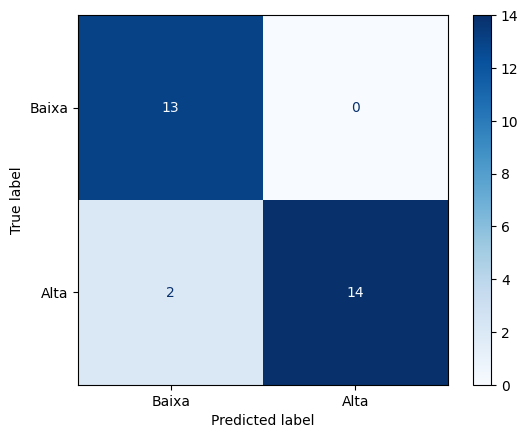

In [104]:
cm_sarimax_display = ConfusionMatrixDisplay(cm_sarimax, display_labels=["Baixa", "Alta"])
print(f"Acurácia do modelo Sarimax: {accuracy_score(real_up[1:], sarimax_up[1:])}")
print(f"Acurácia Balanceada do modelo Sarimax: {balanced_accuracy_score(real_up[1:], sarimax_up[1:])}")
cm_sarimax_display.plot(cmap="Blues");



Acurácia do modelo Prophet Simples: 0.8620689655172413
Acurácia Balanceada do modelo Prophet Simples: 0.8677884615384616


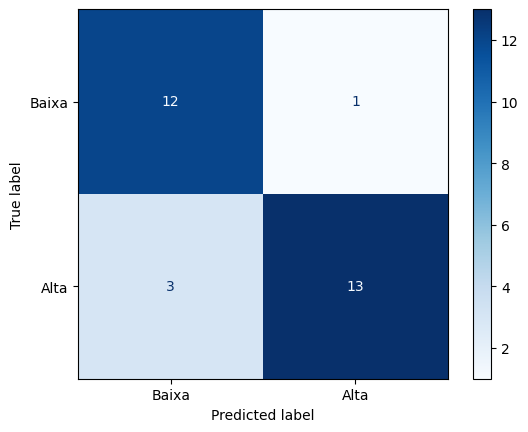

In [102]:
cm_prophet_display = ConfusionMatrixDisplay(cm_prophet, display_labels=["Baixa", "Alta"])
print(f"Acurácia do modelo Prophet Simples: {accuracy_score(real_up[1:], prophet_up[1:])}")
print(f"Acurácia Balanceada do modelo Prophet Simples: {balanced_accuracy_score(real_up[1:], prophet_up[1:])}")
cm_prophet_display.plot(cmap="Blues");



Acurácia do modelo Prophet Otimizado: 0.8620689655172413
Acurácia Balanceada do modelo Prophet Otimizado: 0.8677884615384616


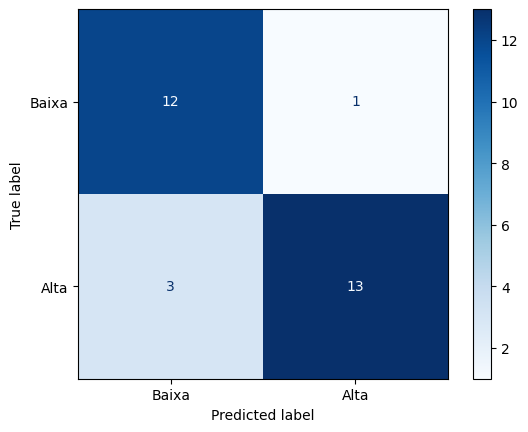

In [103]:
print(f"Acurácia do modelo Prophet Otimizado: {accuracy_score(real_up[1:], prophet2_up[1:])}")
print(f"Acurácia Balanceada do modelo Prophet Otimizado: {balanced_accuracy_score(real_up[1:], prophet2_up[1:])}")
cm_prophet2_display = ConfusionMatrixDisplay(cm_prophet2, display_labels=["Baixa", "Alta"])
cm_prophet2_display.plot(cmap="Blues");